In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from tensorflow.compat.v1.keras.backend import set_session
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings('ignore')

#**Configuring the GPU memory to be used for training purposes**

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.compat.v1.Session(config=config))

def set_seed(sd=8):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn

    seed(sd)
    rn.seed(sd)
    set_random_seed(sd)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**importing the Image Dataset and its respective Captions**

In [5]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = "../content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset"
## The location of the caption file
dir_Flickr_text = "../content/drive/MyDrive/Flickr8k_text (1)/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


#**Finding the captions for each Image**

In [6]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


#**Plotting few Images and their captions from the dataset**

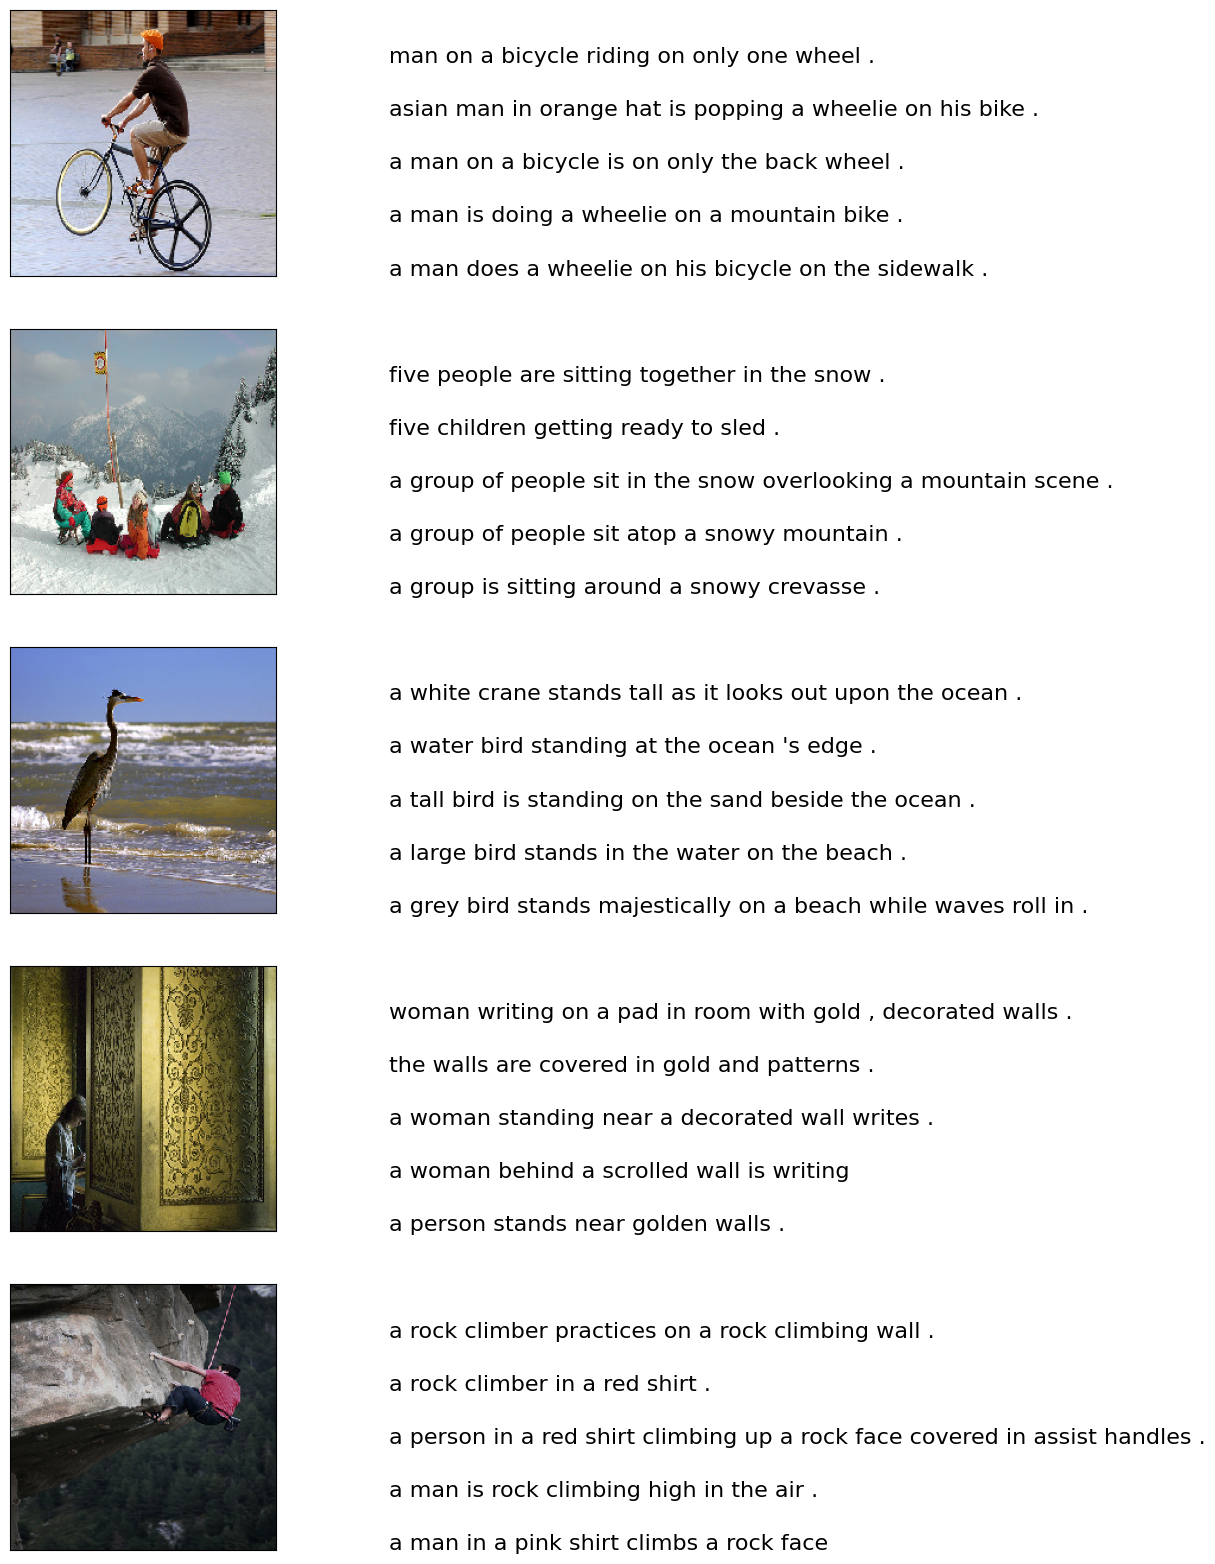

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5  # Displaying 5 images from the dataset
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10,20))

for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=16)
    count += 1
plt.show()

#**Cleaning captions for further Analysis**

In [ ]:
# Defining a function to calculate the top 5 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({'word':list(ct.keys()), "count":list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False)
    dfword = dfword.reset_index()[["word", "count"]]

    return (dfword)

dfword = df_word(df_txt)
dfword.head()

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744


#**Cleaning the captions**


*   The caption dataset contains punctuations, singular words and numerical values that need to be cleaned before it fed to the model.

In [ ]:
import string
text_original = "I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me"

print("Origial sentense: ",text_original)
print("\nRemoving Punctuations...")

# creating a function that removes punctuation in the sentences
def remove_punctuation(text_original):
    text_without_punct = text_original.translate(str.maketrans('','',string.punctuation))
    return text_without_punct

text_without_punct = remove_punctuation(text_original)
print(text_without_punct)

print("\nRemoving a single character...")

# creating a function that removes single character
def removing_single_char(text):
    text_len_greater_than_one = ""
    for word in text.split():
        if len(word) > 1:
            text_len_greater_than_one += " " + word
    return text_len_greater_than_one

text_len_greater_than_one = removing_single_char(text_without_punct)
print(text_len_greater_than_one)

print("\nRemoving numeric values...")

# creating a function that removes numerical values
def remove_numeric(text, printTF=False):
    text_without_num = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("     {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_without_num += " "+ word
    return text_without_num

text_without_num = remove_numeric(text_len_greater_than_one, printTF=True)
print(text_without_num)

Origial sentense:  I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me

Removing Punctuations...
I ate 8 burgers and 4 pizzas its 944 am can you play chess with me

Removing a single character...
 ate burgers and pizzas its 944 am can you play chess with me

Removing numeric values...
     ate        : True
     burgers    : True
     and        : True
     pizzas     : True
     its        : True
     944        : False
     am         : True
     can        : True
     you        : True
     play       : True
     chess      : True
     with       : True
     me         : True
 ate burgers and pizzas its am can you play chess with me


#**Let's applying functions to our data(Image captions)**

In [ ]:
def text_clean(text_original):

    text = remove_punctuation(text_original)
    text = removing_single_char(text)
    text = remove_numeric(text)

    return text

for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt['caption'].iloc[i] = newcaption

#**Plotting top 50 words that occur in the Cleaned Dataset**

Vocabulary Size: 8763


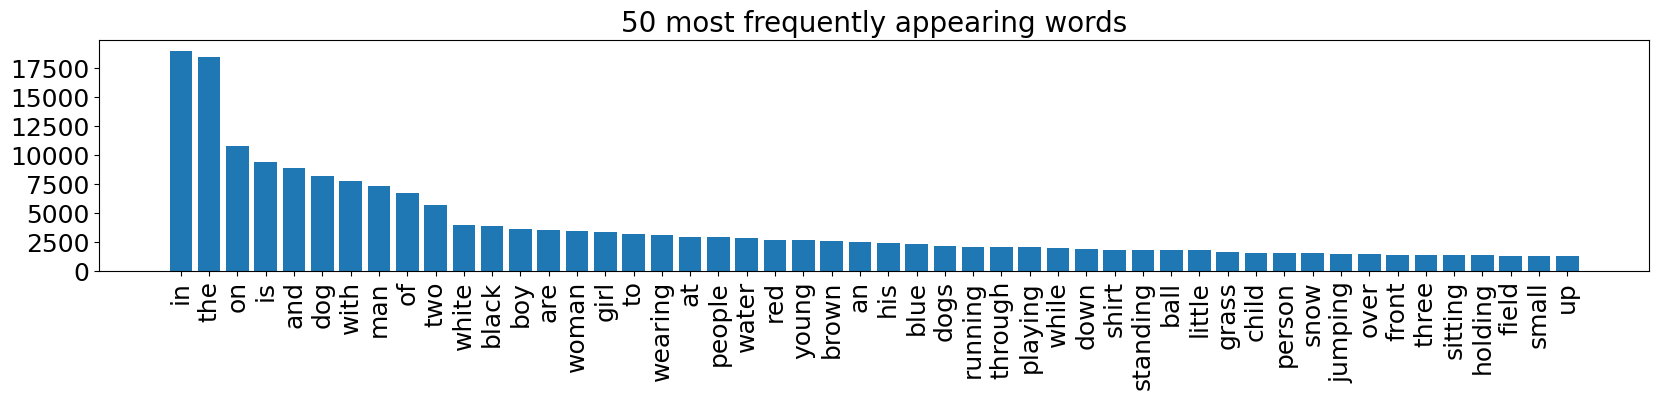

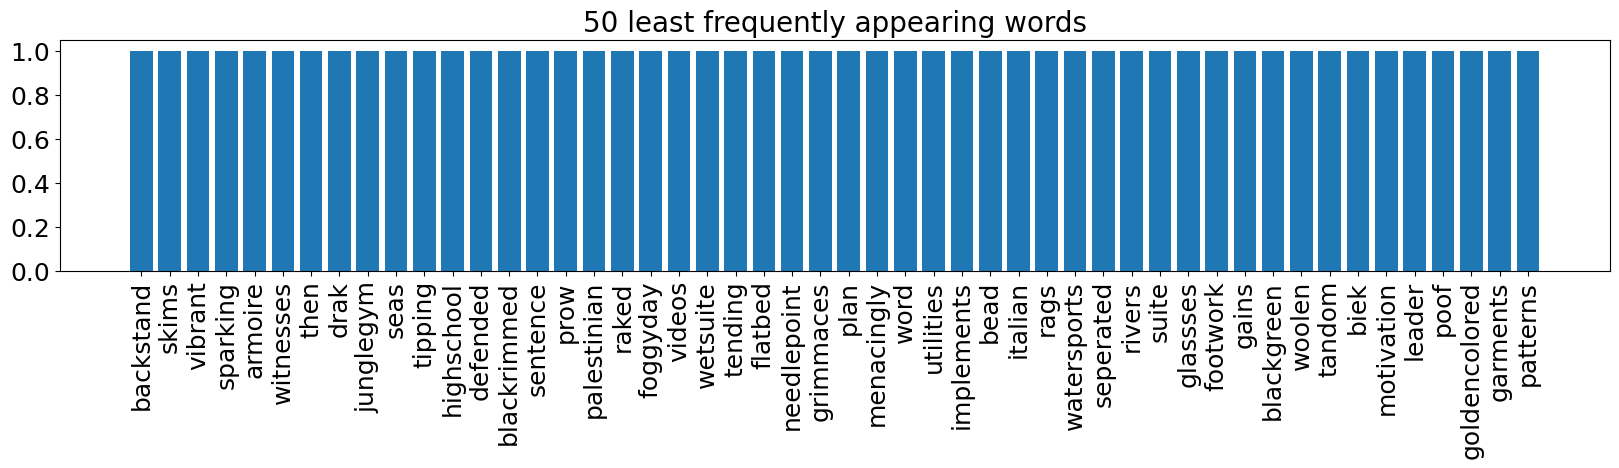

In [ ]:
topn = 50

def plthist(dfsub, title="Plotting top 50 words that occur in the Cleaned Dataset"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=18)
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=18)
    plt.title(title, fontsize=20)
    plt.show()

dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:], title="50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:], title="50 least frequently appearing words")

#**Adding start and end sequence tokens for each captions**
* Start and End Sequence has to be added to the tokens so that it's easier to
identify the captions for the image as each of them are of different length

In [ ]:
from copy import copy
def add_tokens(captions):
    caps = []
    for txt in captions:
        txt = "startseq" + txt + " endseq"
        caps.append(txt)
    return caps
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_tokens(df_txt["caption"])
df_txt0.head(5)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into ...


#**Loading VGG16 model and weights to extract features from the images**

In [ ]:
from keras.applications import VGG16

model_vgg = VGG16(include_top=True, weights=None)
model_vgg.load_weights("../content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#**Deleting the last layer of the Model**
*   we only need feature extraction that's why we gonna exclude last layer of
VGG-16 beacuse this layer is for object classification.

In [ ]:
from keras import models
model = Sequential()
for layer in model_vgg.layers[:-1]: # go through until last layer
    model.add(layer)
final_vgg_model = models.Model(inputs=model.inputs, outputs=model.layers[-1].output)

final_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#**Feature Extraction**
*   the features are extracted from all the images in the dataset. VGG-16 model
gives out 4096 features from the input image of size 224 * 224

In [ ]:
from keras.preprocessing.image import load_img,  img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224  #image size fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix, npix, 3)
data = np.zeros((len(jpgs), npix, npix, 3))
for i, name in enumerate(jpgs):
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)
    nimage = preprocess_input(image)

    y_pred = final_vgg_model.predict(nimage.reshape((1,)+ nimage.shape[:3]))
    images[name] = y_pred.flatten()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step


#**plotting similar images from the dataset**
* For this we have to first create a cluster and find which images are belongs together. hence PCA is used to reduce the dimensions of the features which we got from VGG-16 feature extraction from 4096 to 2.
* first the cluster are plotted and few examples are taken from the bunch for displaying

In [ ]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))

pca = PCA(n_components=2)

y_pca = pca.fit_transform(encoder)

In [ ]:
## some selected pictures that are cretaing clusters
# these are just to display the related images from the dataset

picked_picture = OrderedDict()
picked_picture["yellow"] = [1293, 3389, 6269, 5585, 2361]
picked_picture["green"] = [2336, 3585, 1790, 5377, 7504]
picked_picture["magenta"] = [2170, 4732, 761, 4851, 2820]
picked_picture["blue"] = [4559, 1850, 410, 401, 3825]
picked_picture["purple"] = [5074, 2563, 6545, 4978, 7895]
picked_picture["red"] = [6360, 5979, 7205, 5340, 5138]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0], y_pca[:,1], c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow, y_pca[irow,:], color="black", alpha=0.5)
for color, irows in picked_picture.items():
    for irow in irows:
        ax.annotate(irow, y_pca[irow, :], color=color)
ax.set_xlabel("pca embedding 1", fontsize=30)
ax.set_ylabel("pca embedding 2", fontsize=30)
plt.show()

## plot the images
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_picture.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(len(picked_picture), 5, count, xticks=[], yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec, color))
plt.show()

#**Merging the images and the captions for training**

In [ ]:
dimages, keepindex = [], []
# creating a dataframe where only first caption is taken for model training
df_txt0 = df_txt0.loc[df_txt0["index"].values == '0',:]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

# fname are the names of the image
fnames = df_txt0["filename"].iloc[keepindex].values
# dcaptions contains captions of the images
dcaptions = df_txt0["caption"] .iloc[keepindex].values
# dimages are the actual features of the images
dimages = np.array(dimages)

In [ ]:
df_txt0.head()

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up se...
5,1001773457_577c3a7d70.jpg,0,startseq black dog and spotted dog are fightin...
10,1002674143_1b742ab4b8.jpg,0,startseq little girl covered in paint sits in ...
15,1003163366_44323f5815.jpg,0,startseq man lays on bench while his dog sits ...
20,1007129816_e794419615.jpg,0,startseq man in an orange hat starring at some...


#**Tokenizing the captions for further processing**
* as the model can not take texts as an input, they need to converted into vectors

In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocubulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:3])

Vocubulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2]]


#**Splitting the training and testing Data**

In [ ]:
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],
           dtexts[Ntest:Ntest+Nval],
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

#**Finding the Max Lenghth of caption**

In [ ]:
maxlen = np.max([len(text) for text in dtexts])
minlen = np.min([len(text) for text in dtexts])
print("Min length of caption: {} and Max length of caption: {}".format(minlen, maxlen))

Min length of caption: 2 and Max length of caption: 30


#**Processing the captions and images as per the model standard input type**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to


            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

#**Buiding the LSTM model**

In [ ]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
print(vocab_size)

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)

se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256, name="CaptionFeature2")(se2)
# combining model for decoder

decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation="relu")(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

#**Training the LSTM Model**

In [ ]:
# fit model
from time import time
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir="log/{}".format(time()))

hist = model.fit([Ximage_train, Xtext_train], ytext_train, epochs=6, verbose=2, batch_size=32, validation_data=([Ximage_val, Xtext_val], ytext_val), callbacks=[tensorboard])

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#**Generating captions on a small set of images**
* After the model finishes training we can test out its performance on the some of the test images to figure out if the generated captions are good enough. if the generated captions are good enough we can generate the captions for the whole dataset.

In [ ]:
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " "+ newword
        if newword == "endseq":
            break
    return in_text

npic = 5
npix = 224
target_size = (npix, npix, 3)
count = 1

fig = plt.figure(figsize=(10,20))

for jpgfnm, image_feature in zip(fnm_test[15:20], di_test[15:20]):
    ## images
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0, 0.5, caption, fontsize=20)
    count += 1

plt.show()

#**Evaluating the Model Performance**
* After the model is trained we have to test the models prediction capabilities on test dataset. Traditional accuracy metrics can't be used on predictions. For text evalutions we have a metric called as BLEU Score.BLEU stands for Bilingual Evaluation Understidy. it is a score for comparing a candidate text to one or more reference tex

In [ ]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference = "I do like dog"
reference = [reference.split()]

from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(reference, hypothesis)))

In [ ]:
hypothesis2 = "I love dog!".split()
print("BLEU={:4.3f}".format(sentence_bleu(reference,  hypothesis2)))

#**Generating captions for the whole testset and finding BLEU score**

In [ ]:
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

nkeep = 5
pred_strong, pred_weak, bleus = [], [], []
count = 0

for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 200 == 0:
        print("   {:4.2f}% is done..".format(100*count/float(len(fnm_test))))

    caption_true = [index_word[i] for i in tokenized_text]
    caption_true = caption_true[1:-1]
    ## captions

    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]

    bleu = sentence_bleu([caption_true], caption)
    bleus.append(bleu)

    if bleu > 0.7 and len(pred_strong) < nkeep:
        pred_strong.append((bleu, jpgfnm, caption_true, caption))
    elif bleu < 0.3 and len(pred_weak) < nkeep:
        pred_weak.append((bleu, jpgfnm, caption_true, caption))

In [ ]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

#**Good and Bad captions examples from the model**
* We can check out some of the images the generated caption's quality. some times due to the complex nature of the images the generated captions are not acceptable.

In [ ]:
def plot_images(pred_weak):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return strue
    npix = 224
    target_size = (npix, npix, 3)
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_weak)
    for pw in pred_weak:
        bleu, jpgfnm, caption_true, caption = pw
        ## image
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)

        ax = fig.add_subplot(npic, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0, 0.7, "true:" + caption_true, fontsize=20)
        ax.text(0, 0.4, "pred:" + caption, fontsize=20)
        ax.text(0, 0.1, "BLEU: {}".format(bleu), fontsize=20)
        count += 1
    plt.show()

print("Weak Captions")
plot_images(pred_weak)
print("Strong Captions")
plot_images(pred_strong)

#**Conclusion**

* The model has been successfully trained to generate the captions as expected for the images. The caption generation has constantly been improved by fine tuning the model with different hyper parameter. Higher BLEU score indicates that the generated captions are very similar to those of the actual caption present on the images.
* The validation loss falls upto 5th epoch and then increases afterwards, while the training loss still continues falling.
* The following were the major outcomes and a observations of the training process and testing the model on the test data:

* The validation loss increases after 5th epoch in most cases even though the training loss decreases over time. This indicates that the model is over fitting and the training needs to stop.

* Higher BLEU score doesn't aways translate to better generated captions. If the model overfits on your training data, it will lead the model to go through details in the image and generate out captions which don't make sense. it can be seen in the strong and the weak captions generated above.